In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA

import numpy as np
import time
import matplotlib.pyplot as plt
from visualization import plot_metrics
from data_processing import create_sequences, sort_results
from models import RNN, GRU, LSTM
from train import train_and_evaluate

In [2]:
mapping = {'NE': 1, 'SE': 2, 'NW': 3, 'cv': 4}

In [3]:
pollution_data = pd.read_csv("datasets/pollution_data.csv")
pollution_data.wnd_dir = pollution_data.wnd_dir.map(mapping)

pollution_data.set_index('date', inplace=True, drop=True)
pollution_data.index = pd.to_datetime(pollution_data.index)
pollution_data.sample(5)
pollution_data

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,2,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,2,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,2,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,2,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,3,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,3,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,3,242.70,0,0


In [4]:
multivar_pollution_data = pollution_data
univar_pollution_data = pd.DataFrame(pollution_data["pollution"])


In [5]:
scale = MinMaxScaler()
mv_columns = multivar_pollution_data.columns

mv_data_scaled = multivar_pollution_data.copy()
mv_data_scaled[mv_columns] = scale.fit_transform(mv_data_scaled[mv_columns])
mv_data_scaled.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,0.129779,0.352941,0.245902,0.527273,0.333333,0.002290,0.000000,0.0
2010-01-02 01:00:00,0.148893,0.367647,0.245902,0.527273,0.333333,0.003811,0.000000,0.0
2010-01-02 02:00:00,0.159960,0.426471,0.229508,0.545455,0.333333,0.005332,0.000000,0.0
2010-01-02 03:00:00,0.182093,0.485294,0.229508,0.563636,0.333333,0.008391,0.037037,0.0
2010-01-02 04:00:00,0.138833,0.485294,0.229508,0.563636,0.333333,0.009912,0.074074,0.0


In [6]:
uv_col = univar_pollution_data.columns
uv_data_scaled = univar_pollution_data.copy()
uv_data_scaled[uv_col] = scale.fit_transform(mv_data_scaled[uv_col])


In [7]:
mv_num_features = mv_data_scaled.shape[1]
uv_num_features = uv_data_scaled.shape[1]

window_size = 100


In [8]:
uv_data_scaled = uv_data_scaled.reset_index(drop=True)
mv_data_scaled = mv_data_scaled.reset_index(drop=True)


In [9]:
uv_sequences_normalized, uv_labels_normalized = create_sequences(uv_data_scaled, window_size)
mv_sequences_normalized, mv_labels_normalized = create_sequences(mv_data_scaled, window_size)


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
uv_total_samples = uv_sequences_normalized.shape[0]
uv_split_index = int(uv_total_samples * 0.8)  # 80% for training, 20% for testing

uv_X_train = torch.tensor(uv_sequences_normalized[:uv_split_index, :, np.newaxis], dtype=torch.float32)
uv_y_train = torch.tensor(uv_labels_normalized[:uv_split_index], dtype=torch.float32)
uv_X_test = torch.tensor(uv_sequences_normalized[uv_split_index:, :, np.newaxis], dtype=torch.float32)
uv_y_test = torch.tensor(uv_labels_normalized[uv_split_index:], dtype=torch.float32)

mv_total_samples = mv_sequences_normalized.shape[0]
mv_split_index = int(mv_total_samples * 0.8)  # 80% for training, 20% for testing

# Split the data
mv_X_train = torch.tensor(mv_sequences_normalized[:mv_split_index, :, np.newaxis], dtype=torch.float32)
mv_y_train = torch.tensor(mv_labels_normalized[:mv_split_index], dtype=torch.float32)
mv_X_test = torch.tensor(mv_sequences_normalized[mv_split_index:, :, np.newaxis], dtype=torch.float32)
mv_y_test = torch.tensor(mv_labels_normalized[mv_split_index:], dtype=torch.float32)



In [12]:
uv_train_dataset = TensorDataset(uv_X_train, uv_y_train)
uv_test_dataset = TensorDataset(uv_X_test, uv_y_test)
mv_train_dataset = TensorDataset(mv_X_train, mv_y_train)
mv_test_dataset = TensorDataset(mv_X_test, mv_y_test)

In [13]:
batch_size = 64

uv_train_loader = DataLoader(uv_train_dataset, batch_size=batch_size, shuffle=True)
uv_test_loader = DataLoader(uv_test_dataset, batch_size=batch_size, shuffle=False)
mv_train_loader = DataLoader(mv_train_dataset, batch_size=batch_size, shuffle=True)
mv_test_loader = DataLoader(mv_test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
uv_input_size = uv_num_features
mv_input_size = mv_num_features
hidden_size = 20
num_layers = 2
output_size = 1

In [15]:
uv_rnn_model = RNN(uv_input_size, hidden_size, output_size, num_layers).to(device)
uv_gru_model = GRU(uv_input_size, hidden_size, output_size, num_layers).to(device)
uv_lstm_model = LSTM(uv_input_size, hidden_size, output_size, num_layers).to(device)

mv_rnn_model = RNN(mv_input_size, hidden_size, output_size, num_layers).to(device)
mv_gru_model = GRU(mv_input_size, hidden_size, output_size, num_layers).to(device)
mv_lstm_model = LSTM(mv_input_size, hidden_size, output_size, num_layers).to(device)

In [16]:
for inputs, targets in uv_train_loader:
    inputs = inputs.squeeze(2)  

    print(inputs.shape)
    print(targets.shape)
    break

torch.Size([64, 100, 1])
torch.Size([64])


In [17]:

criterion = nn.MSELoss()
uv_rnn_optimizer = optim.Adam(uv_rnn_model.parameters(), lr=0.001)
mv_rnn_optimizer = optim.Adam(mv_rnn_model.parameters(), lr=0.001)

uv_rnn_training_result = train_and_evaluate(uv_rnn_model, uv_train_loader, uv_test_loader, criterion, uv_rnn_optimizer, 30, device)
mv_rnn_training_result = train_and_evaluate(mv_rnn_model, mv_train_loader, mv_test_loader, criterion, mv_rnn_optimizer, 30, device)


Epoch [1/30]: Train Loss: 0.0026, Train RMSE: 0.0431, Train MAE: 1.8681, Val Loss: 0.0007, Val RMSE: 0.0230, Val MAE: 0.9473
Epoch [2/30]: Train Loss: 0.0008, Train RMSE: 0.0269, Train MAE: 0.9982, Val Loss: 0.0006, Val RMSE: 0.0219, Val MAE: 0.8741
Epoch [3/30]: Train Loss: 0.0008, Train RMSE: 0.0261, Train MAE: 0.9450, Val Loss: 0.0008, Val RMSE: 0.0252, Val MAE: 1.1686
Epoch [4/30]: Train Loss: 0.0008, Train RMSE: 0.0265, Train MAE: 0.9584, Val Loss: 0.0006, Val RMSE: 0.0219, Val MAE: 0.9084
Epoch [5/30]: Train Loss: 0.0008, Train RMSE: 0.0264, Train MAE: 0.9647, Val Loss: 0.0007, Val RMSE: 0.0223, Val MAE: 0.9284
Epoch [6/30]: Train Loss: 0.0008, Train RMSE: 0.0263, Train MAE: 0.9522, Val Loss: 0.0006, Val RMSE: 0.0218, Val MAE: 0.8230
Epoch [7/30]: Train Loss: 0.0008, Train RMSE: 0.0262, Train MAE: 0.9510, Val Loss: 0.0006, Val RMSE: 0.0217, Val MAE: 0.8924
Epoch [8/30]: Train Loss: 0.0008, Train RMSE: 0.0263, Train MAE: 0.9493, Val Loss: 0.0006, Val RMSE: 0.0211, Val MAE: 0.8224


In [18]:

criterion = nn.MSELoss()
uv_gru_optimizer = optim.Adam(uv_gru_model.parameters(), lr=0.001)
mv_gru_optimizer = optim.Adam(mv_gru_model.parameters(), lr=0.001)

uv_gru_training_result = train_and_evaluate(uv_gru_model, uv_train_loader, uv_test_loader, criterion, uv_gru_optimizer, 30, device)
mv_gru_training_result = train_and_evaluate(mv_gru_model, mv_train_loader, mv_test_loader, criterion, mv_gru_optimizer, 30, device)


Epoch [1/30]: Train Loss: 0.0036, Train RMSE: 0.0493, Train MAE: 2.2255, Val Loss: 0.0008, Val RMSE: 0.0244, Val MAE: 1.0353
Epoch [2/30]: Train Loss: 0.0008, Train RMSE: 0.0271, Train MAE: 0.9899, Val Loss: 0.0006, Val RMSE: 0.0214, Val MAE: 0.8325
Epoch [3/30]: Train Loss: 0.0008, Train RMSE: 0.0261, Train MAE: 0.9398, Val Loss: 0.0006, Val RMSE: 0.0213, Val MAE: 0.8268
Epoch [4/30]: Train Loss: 0.0008, Train RMSE: 0.0260, Train MAE: 0.9241, Val Loss: 0.0006, Val RMSE: 0.0211, Val MAE: 0.8304
Epoch [5/30]: Train Loss: 0.0008, Train RMSE: 0.0258, Train MAE: 0.9183, Val Loss: 0.0006, Val RMSE: 0.0216, Val MAE: 0.8747
Epoch [6/30]: Train Loss: 0.0008, Train RMSE: 0.0260, Train MAE: 0.9318, Val Loss: 0.0006, Val RMSE: 0.0213, Val MAE: 0.8401
Epoch [7/30]: Train Loss: 0.0008, Train RMSE: 0.0258, Train MAE: 0.9241, Val Loss: 0.0006, Val RMSE: 0.0214, Val MAE: 0.8616
Epoch [8/30]: Train Loss: 0.0008, Train RMSE: 0.0260, Train MAE: 0.9418, Val Loss: 0.0006, Val RMSE: 0.0211, Val MAE: 0.8290


In [19]:

criterion = nn.MSELoss()
uv_lstm_optimizer = optim.Adam(uv_lstm_model.parameters(), lr=0.001)
mv_lstm_optimizer = optim.Adam(mv_lstm_model.parameters(), lr=0.001)
uv_lstm_training_result = train_and_evaluate(uv_lstm_model, uv_train_loader, uv_test_loader, criterion, uv_lstm_optimizer, 30, device)
mv_lstm_training_result = train_and_evaluate(mv_lstm_model, mv_train_loader, mv_test_loader, criterion, mv_lstm_optimizer, 30, device)



Epoch [1/30]: Train Loss: 0.0037, Train RMSE: 0.0550, Train MAE: 2.5030, Val Loss: 0.0015, Val RMSE: 0.0349, Val MAE: 1.7011
Epoch [2/30]: Train Loss: 0.0011, Train RMSE: 0.0312, Train MAE: 1.2201, Val Loss: 0.0007, Val RMSE: 0.0235, Val MAE: 0.9713
Epoch [3/30]: Train Loss: 0.0009, Train RMSE: 0.0273, Train MAE: 1.0261, Val Loss: 0.0006, Val RMSE: 0.0216, Val MAE: 0.8607
Epoch [4/30]: Train Loss: 0.0008, Train RMSE: 0.0265, Train MAE: 0.9821, Val Loss: 0.0006, Val RMSE: 0.0216, Val MAE: 0.8465
Epoch [5/30]: Train Loss: 0.0008, Train RMSE: 0.0262, Train MAE: 0.9537, Val Loss: 0.0006, Val RMSE: 0.0216, Val MAE: 0.8455
Epoch [6/30]: Train Loss: 0.0008, Train RMSE: 0.0261, Train MAE: 0.9472, Val Loss: 0.0006, Val RMSE: 0.0215, Val MAE: 0.8531
Epoch [7/30]: Train Loss: 0.0008, Train RMSE: 0.0261, Train MAE: 0.9452, Val Loss: 0.0006, Val RMSE: 0.0214, Val MAE: 0.8374
Epoch [8/30]: Train Loss: 0.0008, Train RMSE: 0.0259, Train MAE: 0.9316, Val Loss: 0.0006, Val RMSE: 0.0210, Val MAE: 0.8116


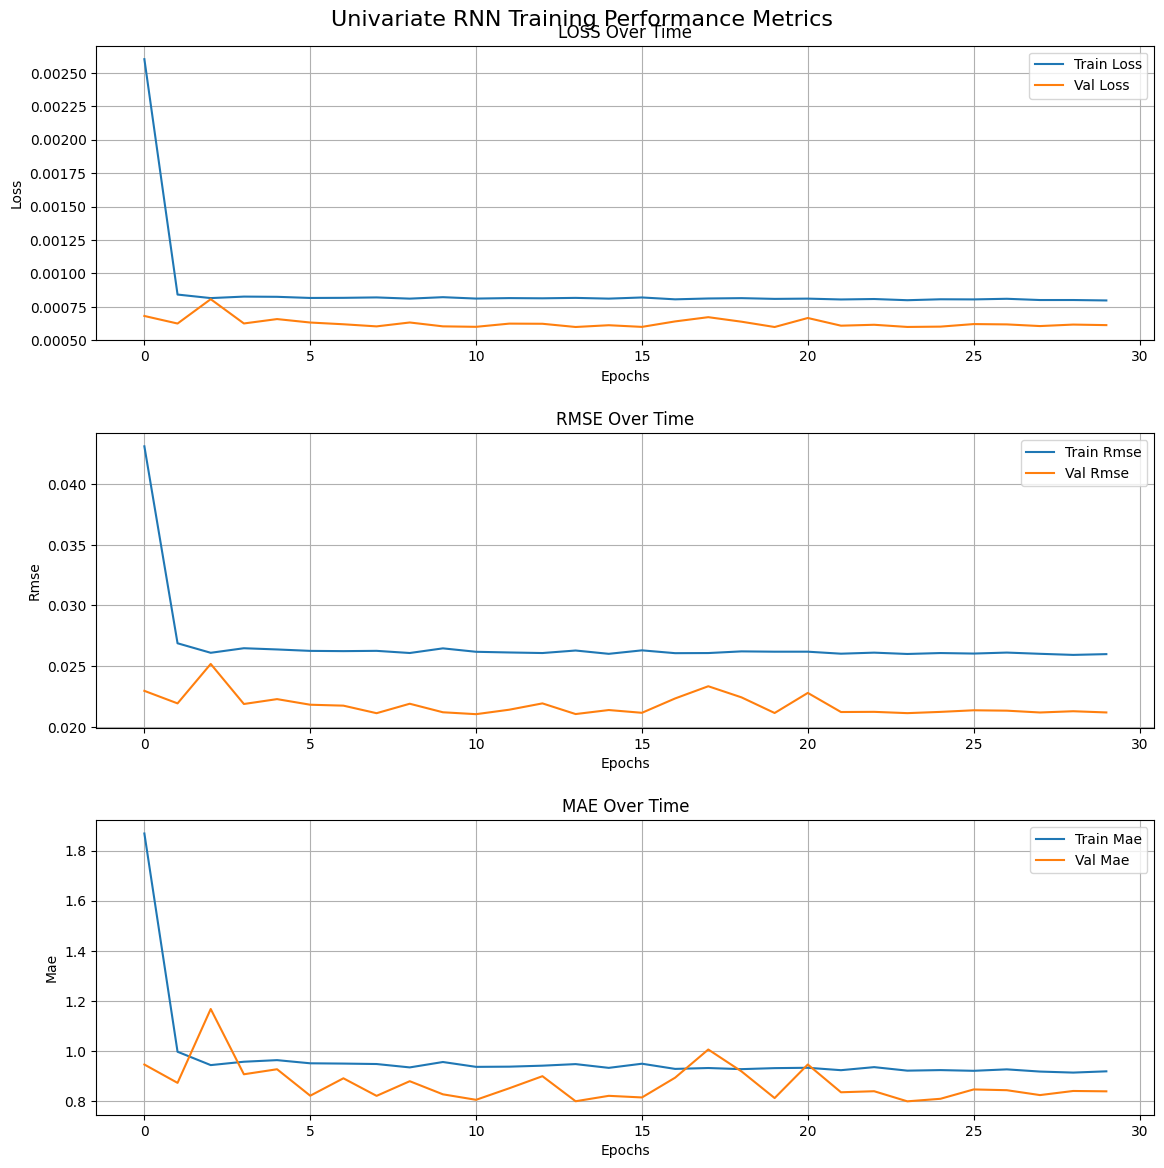

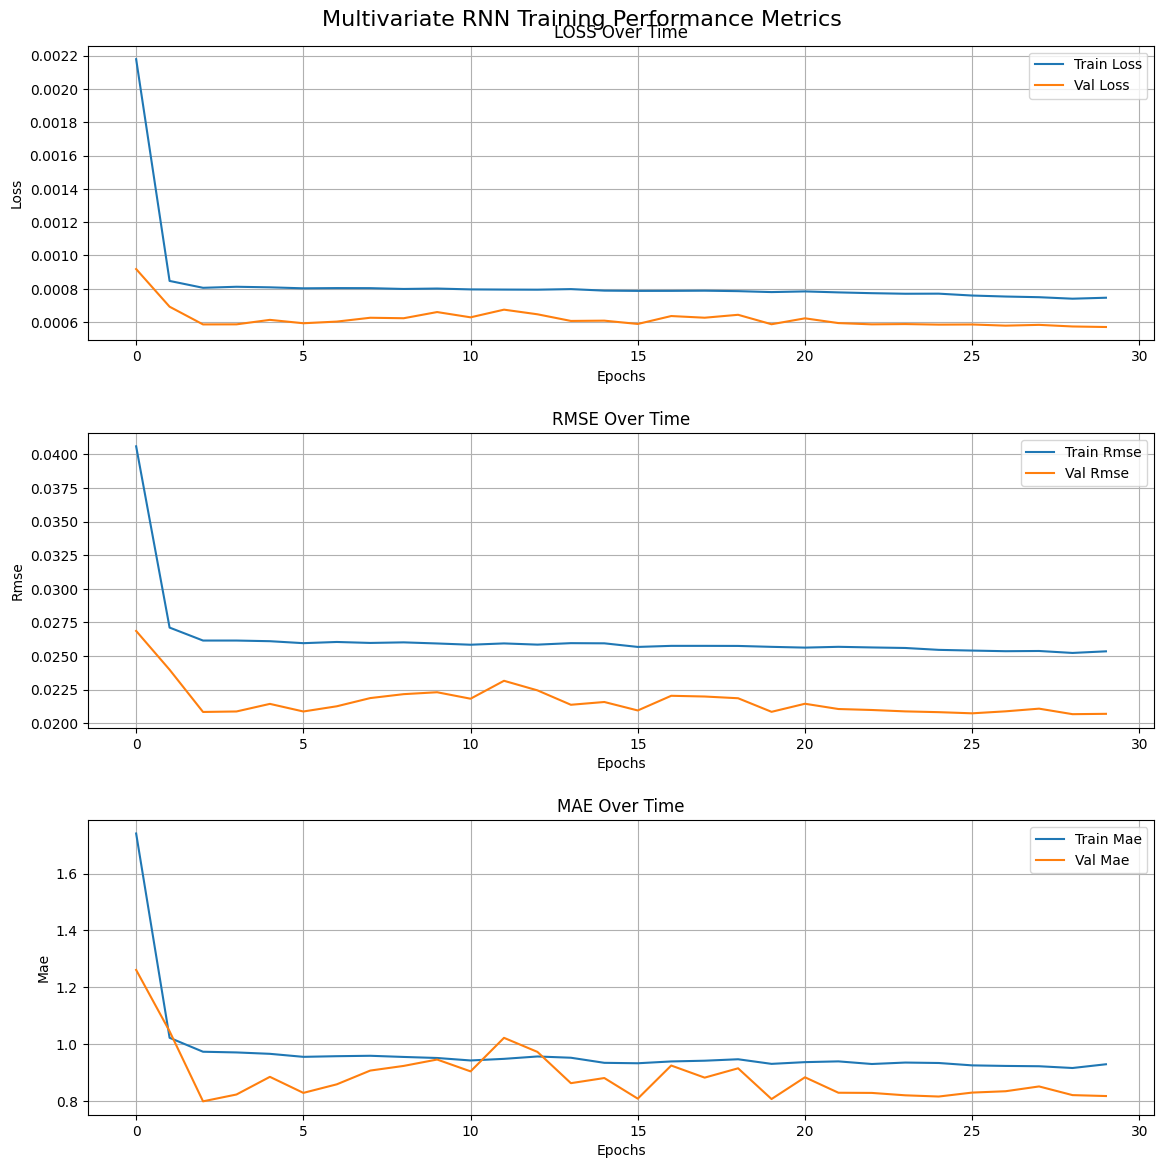

In [20]:
plot_metrics(uv_rnn_training_result, title='Univariate RNN Training Performance Metrics')
plot_metrics(mv_rnn_training_result, title='Multivariate RNN Training Performance Metrics')

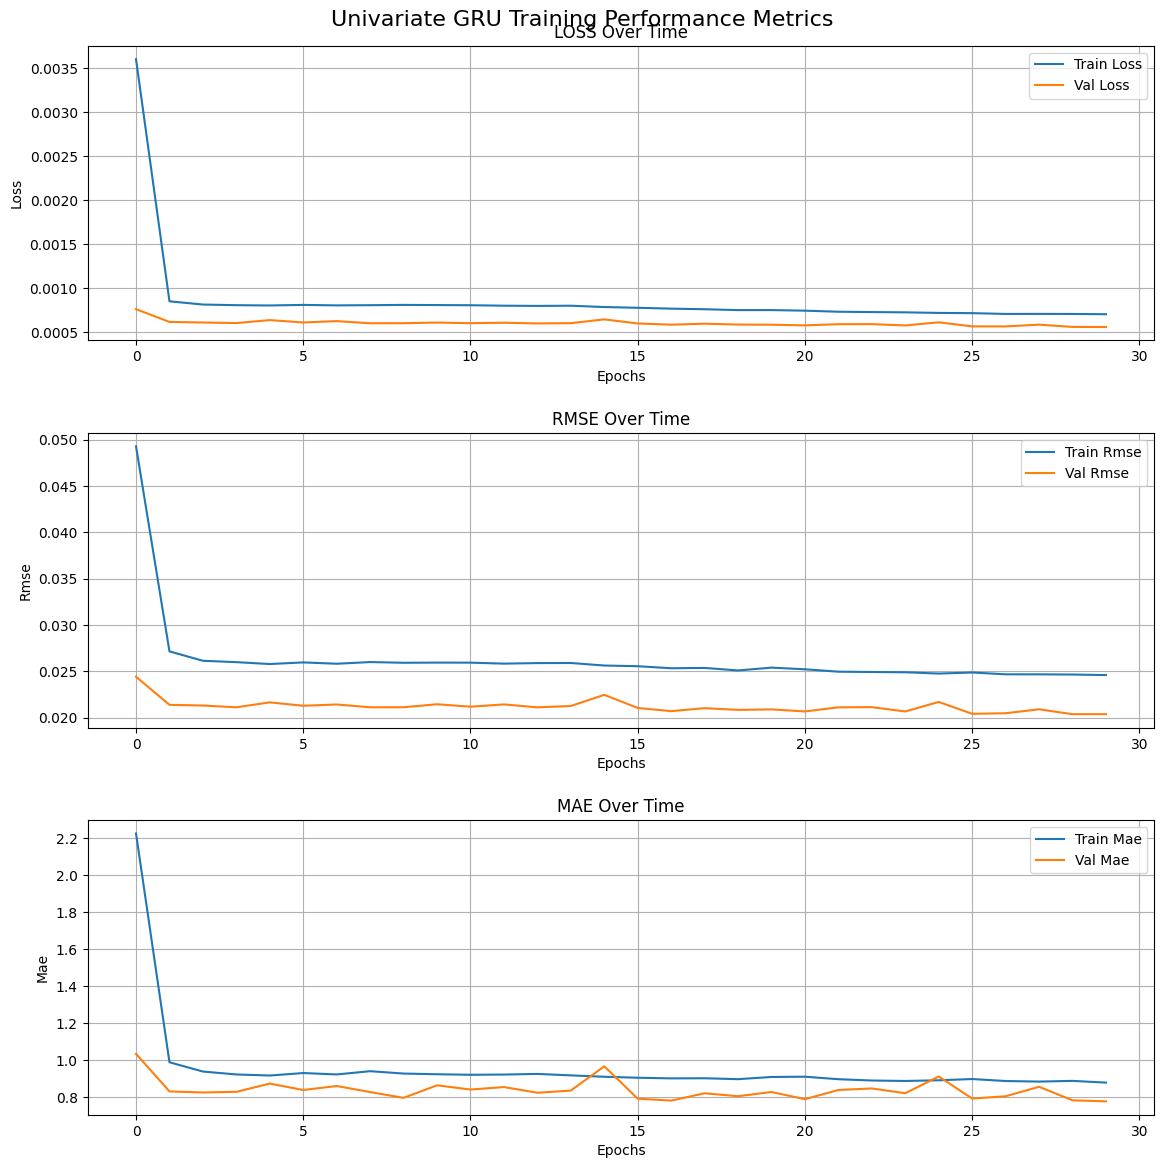

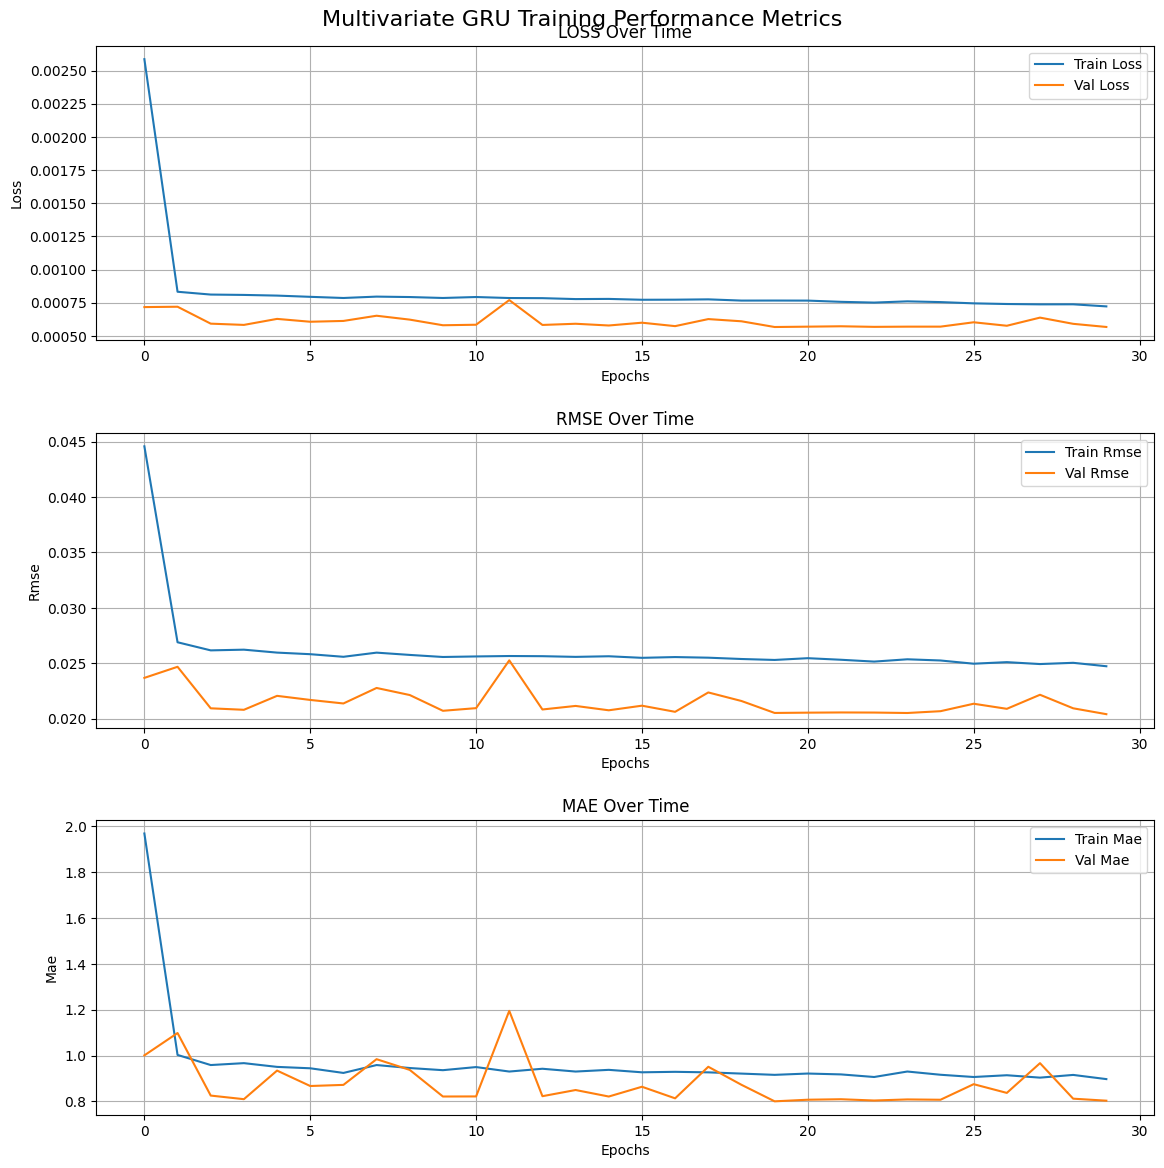

In [21]:
plot_metrics(uv_gru_training_result, title='Univariate GRU Training Performance Metrics')
plot_metrics(mv_gru_training_result, title='Multivariate GRU Training Performance Metrics')

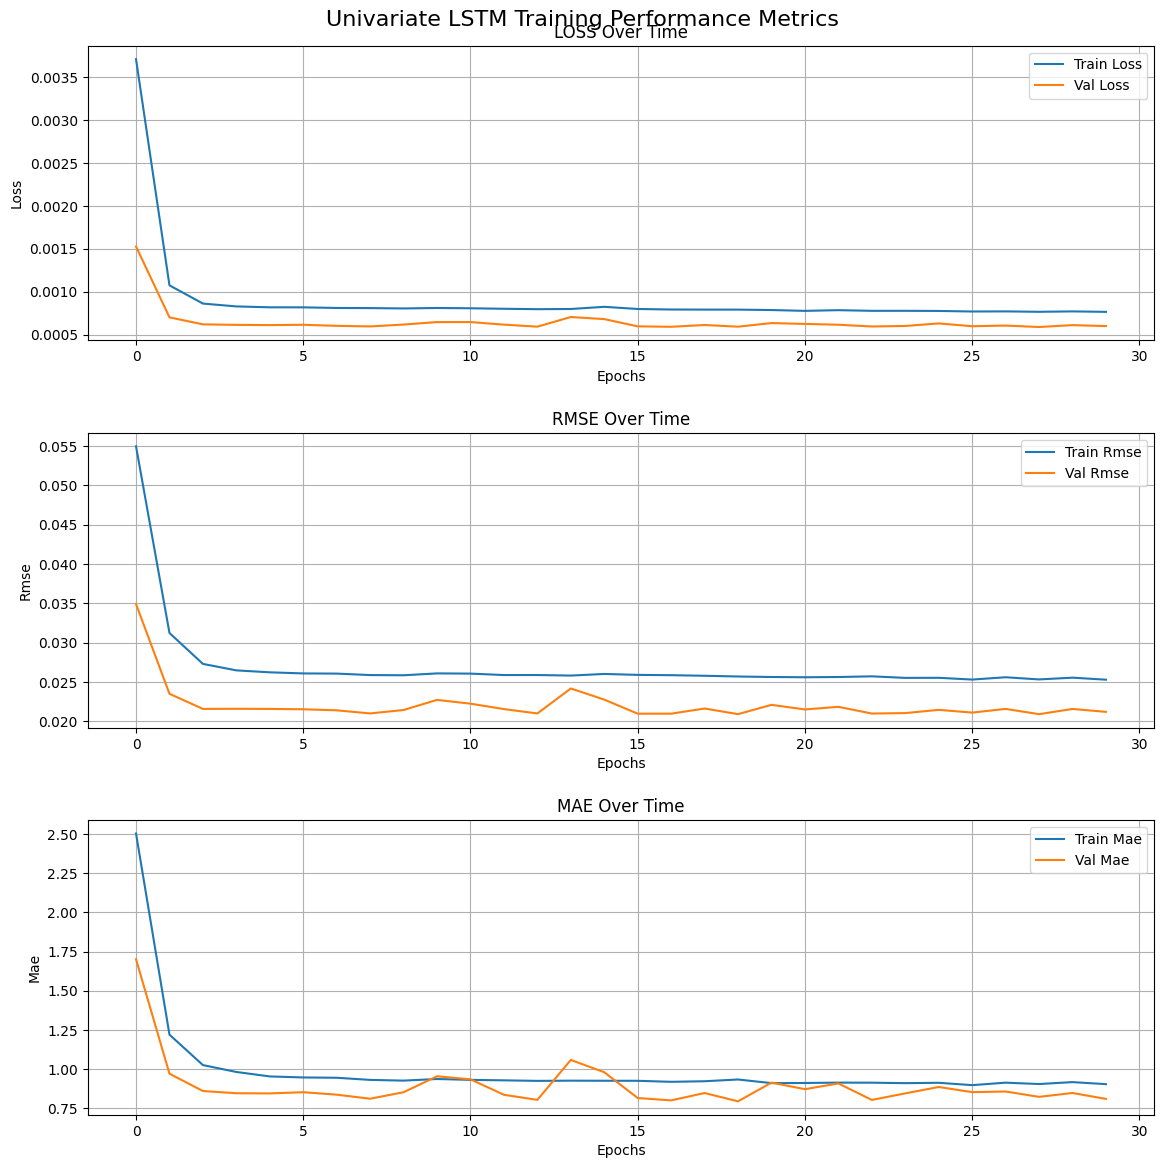

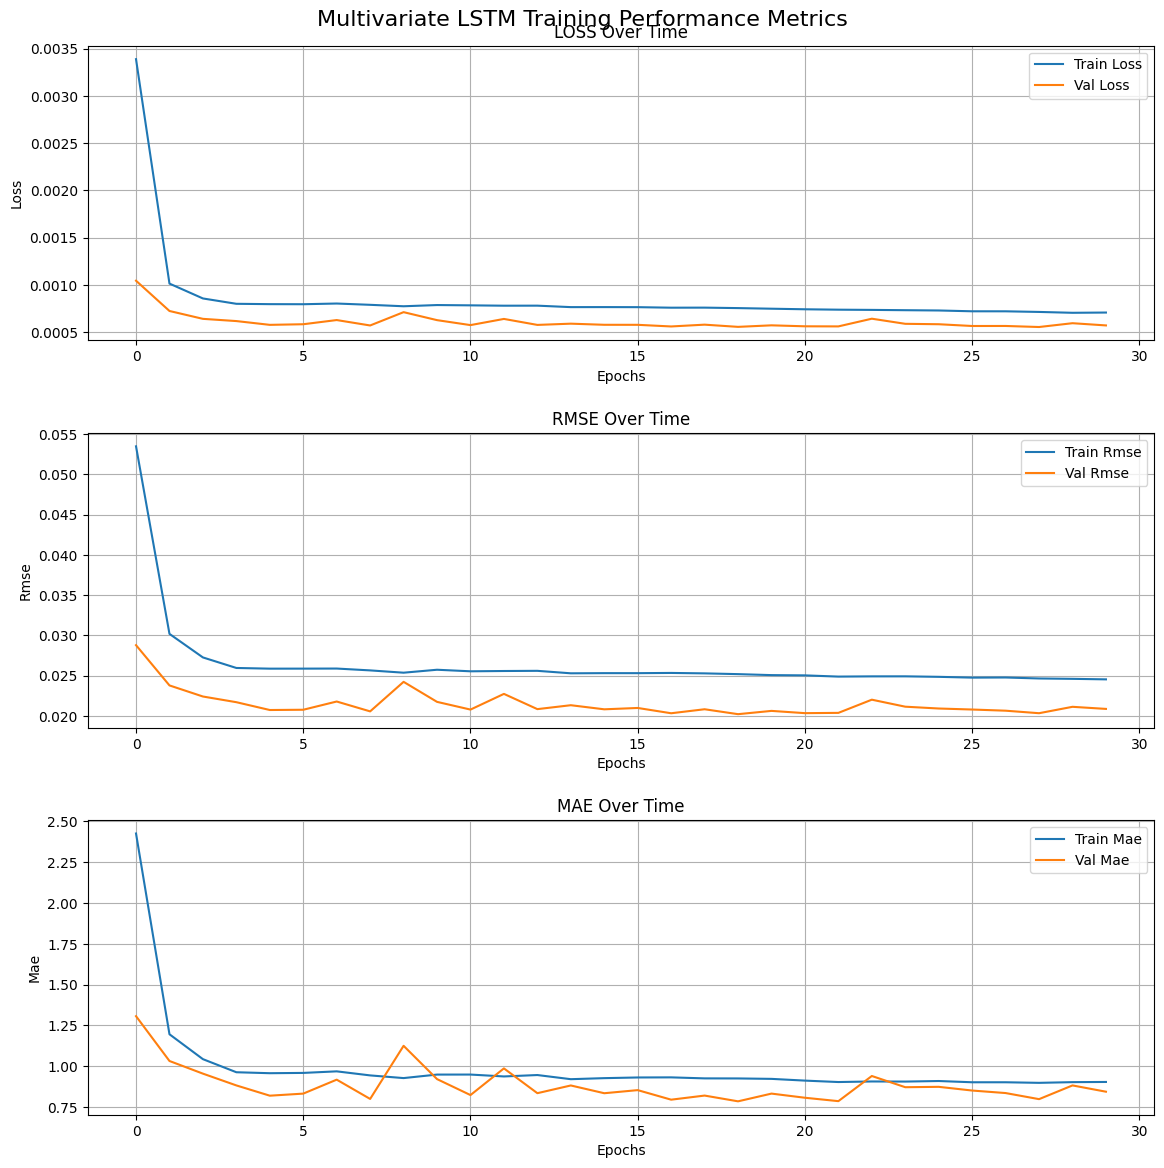

In [22]:
plot_metrics(uv_lstm_training_result, title='Univariate LSTM Training Performance Metrics')
plot_metrics(mv_lstm_training_result, title='Multivariate LSTM Training Performance Metrics')

In [23]:



sorted_results = sort_results(uv_rnn_training_result, mv_rnn_training_result, uv_gru_training_result, mv_gru_training_result, uv_lstm_training_result, mv_lstm_training_result)


In [24]:
results = pd.DataFrame(columns=["model", "train_loss", "val_loss", "train_rmse", "val_rmse", "train_mae", "val_mae"])
models = ["uv_rnn", "mv_rnn", "uv_gru", "mv_gru", "uv_lstm", "mv_lstm"]
results["model"] = models
results["train_loss"] = sorted_results["train_losses"]
results["val_loss"] = sorted_results["val_losses"]
results["train_rmse"] = sorted_results["train_rmses"]
results["val_rmse"] = sorted_results["val_rmses"]
results["train_mae"] = sorted_results["train_maes"]
results["val_mae"] = sorted_results["val_maes"]
results

,model,train_loss,val_loss,train_rmse,val_rmse,train_mae,val_mae
0,uv_rnn,0.000798,0.000613,0.025991,0.021184,0.920151,0.840445
1,mv_rnn,0.000746,0.000570,0.025352,0.020703,0.928849,0.817026
2,uv_gru,0.000701,0.000556,0.024591,0.020371,0.880043,0.778953
3,mv_gru,0.000723,0.000568,0.024721,0.020393,0.897300,0.803130
4,uv_lstm,0.000765,0.000599,0.025303,0.021217,0.904494,0.810362
5,mv_lstm,0.000707,0.000571,0.024548,0.020879,0.903715,0.844067
